In [2]:
import openferro as of
from openferro.interaction import *
from openferro.simulation import *
from openferro.engine import *
from matplotlib import pyplot as plt


In [3]:
latt = of.BravaisLattice3D(8, 8, 8)
pto = of.System(latt, pbc=True)
dipole_field = pto.add_field(name="dipole", ftype="scalar", value=0.75)

double_well = self_energy_R1_onsite
pto.add_self_interaction('double_well', field_name="dipole", energy_engine=double_well, parameters={'k2': -0.6, 'alpha': 0.3, 'offset': 0}, enable_jit=True)

ising_couple = self_energy_R1_neighbor_pbc
pto.add_self_interaction('ising_couple', field_name="dipole", energy_engine=ising_couple, parameters={'J1': -0.02, 'J2': -0.02, 'J3': -0.02, 'offset': 0}, enable_jit=True)

print('mass:', pto.get_field_by_name('dipole').get_mass().flatten())
pto.update_force()
print('max force before optimization',pto.get_field_by_name("dipole").get_force().max())
print('average field before optimization',pto.get_field_by_name("dipole").get_values().mean())
minimizer = MDMinimize(pto, max_iter=100, tol=1e-5, dt=0.1)
minimizer.minimize()
equilibrium_field = pto.get_field_by_name("dipole").get_values().copy()
print('max force after optimization',pto.get_field_by_name("dipole").get_force().max())
print('average field after optimization',pto.get_field_by_name("dipole").get_values().mean())




mass: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [7]:
temp_list = [ 300,400,500,600,700,800,900]
# average_field = np.zeros(len(temp_list))
log_freq = 100
total_time = 100000
dt = 0.1
relax_steps = int(1000/dt)
total_steps = int(total_time / dt)
niters = total_steps // log_freq
field_history = []
for it, temperature in enumerate(temp_list):
    simulation = SimulationNVTLangevin(pto, dt=dt, temperature=temperature, gamma=1/(100*dt))
    simulation.system.get_field_by_name('dipole').set_values(equilibrium_field.copy())
    simulation.init_velocity(mode='gaussian')
    simulation.step(relax_steps)
    print('T={}K'.format(temperature))
    average_field = []
    for ii in range(niters):
        simulation.step(log_freq)
        # print('velocity:', pto.get_field_by_name('dipole').get_velocity().flatten())
        # print('field:', pto.get_field_by_name('dipole').get_values().flatten())
        pot_E = pto.calc_potential_energy()
        kin_E = pto.calc_kinetic_energy()
        total_E = pot_E + kin_E
        # average_field[it] += pto.get_field_by_name('dipole').get_values().mean() / niters
        average_field.append(pto.get_field_by_name('dipole').get_values().mean())
        # print('=================T={}K, iter={}======================='.format(temperature, ii))
        # print('pot energy:', pot_E)
        # print('kine energy:', kin_E)
        # print('total energy:', total_E)
        # print('temperature:', pto.calc_temp_by_name('dipole'))
        # print('average field:', average_field)
        # print('field:', pto.get_field_by_name('dipole').get_values().flatten())
    field_history.append(average_field)
field_history = jnp.array(field_history)


T=300K
T=400K
T=500K
T=600K
T=700K
T=800K
T=900K


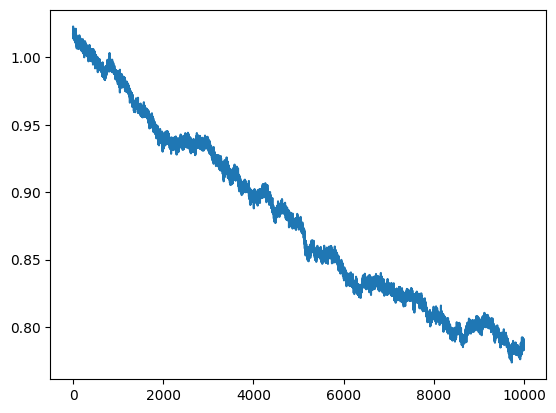

In [15]:
plt.plot(field_history[2])

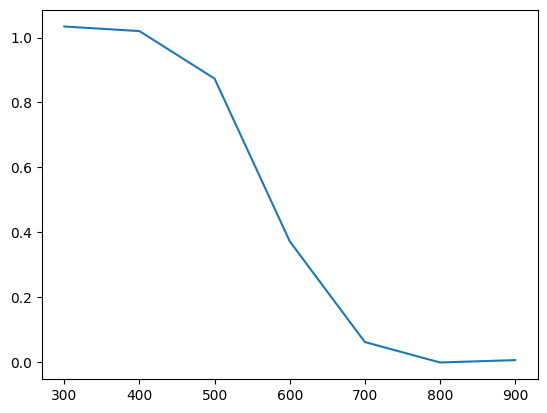

In [16]:
# temp_list = [300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]
# average_field = np.load('field_T.npy')
plt.plot(temp_list, field_history[:,500:].mean(-1))


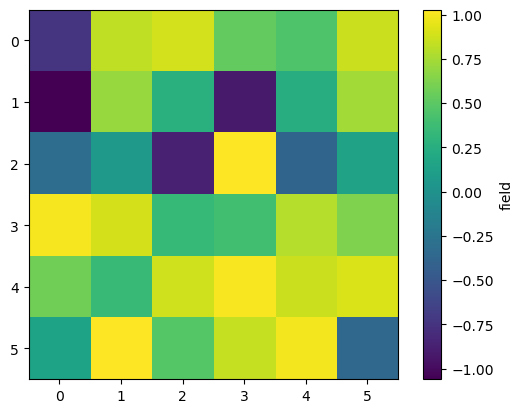

In [5]:
plt.imshow(pto.get_field_by_name('dipole').get_values()[:,:,0,0])
colorbar = plt.colorbar()
colorbar.set_label('field')
plt.show()